In [1]:
# -------------------------------------------------------
# Assignment 2
# Written by Cameron Williams 40124446 and Brandon Williams 40124304
# For COMP 472 Section AK-X – Summer 2021
# --------------------------------------------------------

In [2]:
# imports
from requests import get
from bs4 import BeautifulSoup
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import math

# global variables
dataSet = [] #[[reviewLink, review number on that link, 'rating'], ...]
numPositiveReviews = 0
numNegativeReviews = 0
trainingDataSet = []
testingDataSet = []
vocabulary = {} # {'word': '[posFreq, negFreq]',...}
totalPositiveWords = 0
totalNegativeWords = 0
probPositive = 0
probNegative = 0

# Scraping IMDB for The Office Episode reviews

In [3]:
def scraping():
    url = "https://www.imdb.com/title/tt0386676/episodes?season=1" # url for The Office imdb episodes, starting at season 1
    html = get(url).text
    bsoup = BeautifulSoup(html, "html.parser")

    # Get number of seasons
    seasons = bsoup.find('select', id = 'bySeason')
    seasons = seasons.find_all('option')
    numSeasons = 0
    for season in seasons:  
        try: 
            if int(season.text) > numSeasons:
                numSeasons = int(season.text)
        except ValueError:
            continue

    # Open data.csv file for writing
    with open("data.csv", "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Name","Season","Review Link","Year"])

        # Loop through all season pages
        for i in range(1, numSeasons + 1):
            url = url[:-1] + str(i)
            html = get(url).text
            bsoup = BeautifulSoup(html, "html.parser")
            episodesList = bsoup.find('div', class_ = 'list detail eplist').find_all('div', class_ = 'list_item')

            # Loop through all eposiode review pages
            for episode in episodesList:
                name = str(episode.find('div', class_ = 'info').strong.a.text)
                reviewLink = episode.find('div', class_ = 'info').strong.a['href']
                reviewLink = "https://www.imdb.com" + reviewLink + "reviews"     
                year = str(episode.find('div', class_ = 'info').find('div', class_ = 'airdate').text).strip().split(' ')[2]
                writer.writerow([name,i,reviewLink,year])
        f.close()
    print("Scraping Done")

# Building the DataSet

In [4]:
def buildingDataSet():
    global dataSet
    global numPositiveReviews
    global numNegativeReviews

    with open('data.csv', mode='r') as f:
        reader = csv.DictReader(f)
        # Go through each episode/row in data.csv
        for episode in reader:
            reviewLink = episode['Review Link']
            html = get(reviewLink).text
            bsoup = BeautifulSoup(html, "html.parser")
            reviewList = bsoup.find('div', class_ = 'lister-list').find_all('div', class_ = 'imdb-user-review')

            # Looping through each review in this episode
            for review in range(len(reviewList)):
                # Get Review rating, skipping ones without ratings. Appending the review to the dataset and logging if its positive or negative.
                if reviewList[review].find('span', class_ = 'rating-other-user-rating') != None:
                    rating = int(reviewList[review].find('span', class_ = 'rating-other-user-rating').span.text)
                    if rating >= 8:
                        dataSet.append([reviewLink, review, 'positive'])
                        numPositiveReviews += 1
                    else:
                        dataSet.append([reviewLink, review, 'negative'])    
                        numNegativeReviews += 1  
        f.close()  

    print('Number of Positive Reviews: ' + str(numPositiveReviews))
    print('Number of Negative Reviews: ' + str(numNegativeReviews))
    print('Length of DataSet: ' + str(len(dataSet)))
    print("buildingDataSet Done")

# Splitting DataSet into Training DataSet and Testing DataSet

In [5]:
def splittingIntoTrainingAndTesting():
    global dataSet
    global trainingDataSet
    global testingDataSet

    # Splitting DataSet into training data set (half the positive and negative reviews) and into the testing data set
    # Note: for a more informed Classifier the training data will be from reviews throughout the entierty of the show (every other posiitve, then negative review)
    everyOtherPositive = True
    everyOtherNegative = True
    for review in dataSet:
        if review[2] == 'positive':
            if everyOtherPositive:
                trainingDataSet.append(review)
                everyOtherPositive = False
            else:
                everyOtherPositive = True
                testingDataSet.append(review)
        if review[2] == 'negative':
            if everyOtherNegative:
                trainingDataSet.append(review)
                everyOtherNegative = False
            else:
                everyOtherNegative = True
                testingDataSet.append(review)

    print('Length of Training DataSet: ' + str(len(trainingDataSet)))
    print('Length of Testing DataSet: ' + str(len(testingDataSet)))    
    print("splittingIntoTrainingAndTesting Done")

# Training DataSet -> Vocabulary (word frequency)

In [6]:
def buildingVocabulary():
    global vocabulary
    global trainingDataSet

    # Collecting stop words from stopword.txt
    stopWords = []
    with open('stopword.txt') as f:
        line = f.readline()
        while line:
            stopWords.append(line.strip())
            line = f.readline()
        f.close()
    wordsAlreadyRemoved = []

    itr = 0
    # Loop through all reviews in the training data set
    print('Building Vocabulary with all ' + str(len(trainingDataSet)) + ' reviews in the training data set...')
    for review in trainingDataSet:
        itr +=1
        reviewLink = review[0]
        html = get(reviewLink).text
        bsoup = BeautifulSoup(html, "html.parser")
        reviewList = bsoup.find('div', class_ = 'lister-list').find_all('div', class_ = 'imdb-user-review')

        # the text of the review
        reviewText = str(reviewList[review[1]].find('div', class_ = 'text show-more__control').text)

        # Tokenize and lowercase and clean words in the review text (remove everything but words and spaces)
        reviewText = reviewText.lower()
        reviewText = reviewText.replace('.', ' ')
        reviewText = re.sub(r'[^a-zA-Z \'-]+', '', reviewText)
        wordsInReview = reviewText.split(' ')
        wordsInReview = list(filter(None, wordsInReview))

        # Remove stop words and appending them without duplicates as to not have huge file 
        for word in list(wordsInReview):
            if word in stopWords:
                wordsInReview.remove(word)
                if word not in wordsAlreadyRemoved:
                    wordsAlreadyRemoved.append(word)

        # Add words and their frequency from current review into vocabulary, using hash table (dictionary) to save performace
        delta = 1 # plus 1 delta smooting
        for word in wordsInReview:
            if review[2] == 'positive':
                if word in vocabulary:
                    vocabulary[word] = [vocabulary[word][0] + 1, vocabulary[word][1]] # update (increment right value)
                else:
                    vocabulary[word] = [1 + delta,0 + delta] # add for first time (new unique word)
            else:
                if word in vocabulary:
                    vocabulary[word] = [vocabulary[word][0], vocabulary[word][1] + 1] # update (increment right value)
                else:
                    vocabulary[word] = [0 + delta,1 + delta] # add for first time (new unique word)

    # Wrting removed words to remove.txt
    with open('remove.txt', 'w') as f:
        for removedWord in wordsAlreadyRemoved:
            f.write(removedWord + "\n")
        f.close()

    print("buildingVocabulary Done")

# Building the Model: Compute the frequency and its conditional probability from the Vocabulary

In [7]:
def buildingModel(fileName):
    global totalPositiveWords
    global totalNegativeWords
    global vocabulary
    global trainingDataSet
    global probPositive
    global probNegative

    # Getting total positive and negative words
    totalPositiveWords = 0
    totalNegativeWords = 0
    for word in vocabulary:
        totalPositiveWords += vocabulary[word][0]
        totalNegativeWords += vocabulary[word][1]

    # Writing to model.txt, writing the frequencies and calculating the conditional probabilities
    with open(fileName, 'w') as f:
        number = 0
        for word in vocabulary:
            number += 1
            f.write('No.' + str(number) + ' ' + word)
            f.write('\n' + str(vocabulary[word][0]) + ', ' + str(vocabulary[word][0]/totalPositiveWords) + ', ' + str(vocabulary[word][1]) + ', ' + str(vocabulary[word][1]/                                totalNegativeWords) + '\n')
        f.close()

    # Probability(positive) and Probability(negative)
    numPositiveReviews = 0
    numNegativeReviews = 0
    for review in trainingDataSet:
        if review[2] == 'positive':
            numPositiveReviews += 1
        else:
            numNegativeReviews += 1
    probPositive = numPositiveReviews/(numPositiveReviews + numNegativeReviews)
    probNegative = numNegativeReviews/(numPositiveReviews + numNegativeReviews)
    print('P(Positive) = ' + str(probPositive))
    print('P(Negative) = ' + str(probNegative))
    print("buildingModel Done")

# Testing the model with the Testing DataSet

In [8]:
def testingModel(fileName):
    global testingDataSet
    global probPositive
    global probNegative
    global vocabulary
    global totalPositiveWords
    global totalNegativeWords

    with open(fileName, 'w') as f:
        number = 0
        positiveInstancesThatAreIdentifiedPositive = 0
        positiveInstances = 0
        instancesThatAreIdentifiedPositive = 0
        print('Testing Model with all ' + str(len(testingDataSet)) + ' reviews in the testing data set...')
        for review in testingDataSet:
            reviewLink = review[0]
            html = get(reviewLink).text
            bsoup = BeautifulSoup(html, "html.parser")
            reviewList = bsoup.find('div', class_ = 'lister-list').find_all('div', class_ = 'imdb-user-review')

            # the title and text of the review
            reviewTitle = str(reviewList[review[1]].find('a', class_ = 'title').text)
            reviewText = str(reviewList[review[1]].find('div', class_ = 'text show-more__control').text)

            # Tokenize and lowercase and clean words in the review text (remove everything but words and spaces)
            reviewText = reviewText.lower()
            reviewText = reviewText.replace('.', ' ')
            reviewText = re.sub(r'[^a-zA-Z \'-]+', '', reviewText)
            wordsInReview = reviewText.split(' ')
            wordsInReview = list(filter(None, wordsInReview))

            # Naive Bayes Score, if word is not in vocabulary we skip it
            scorePositive = math.log(probPositive) # it will be the P(ri|positive) or score
            scoreNegative = math.log(probNegative) # it will be the P(ri|nregative) or score
            for word in wordsInReview:    
                if word in vocabulary:
                    scorePositive += math.log(vocabulary[word][0]/totalPositiveWords) # p(word | positive)
                    scoreNegative += math.log(vocabulary[word][1]/totalNegativeWords) # p(word | negative)

            # Classifier result
            classifierResult = max(scorePositive, scoreNegative)
            if classifierResult == scorePositive:
                classifierResult = 'positive'
                instancesThatAreIdentifiedPositive += 1
            else:
                classifierResult = 'negative'

            # Prediction
            prediction = ''
            if classifierResult == review[2]:
                prediction = 'right'
            else:
                prediction = 'wrong'

            # Writing to result.txt, if it cant encode an emoji then reviewTitle is stripped of charatcers that cant be encoded, then its written
            number += 1
            try:
                f.write('No.' + str(number) + ' ' + reviewTitle)
            except UnicodeEncodeError:
                reviewTitle = re.sub(r'[^\x00-\x7F]+', '', reviewTitle)
                f.write('No.' + str(number) + ' ' + reviewTitle)            

            # Collecting Vars for f-measure
            if review[2] == 'positive' and classifierResult == 'positive':
                positiveInstancesThatAreIdentifiedPositive += 1
            if review[2] == 'positive':
                positiveInstances += 1

            f.write(str(scorePositive) + ', ' + str(scoreNegative) + ', ' + classifierResult + ', ' + review[2] + ', ' + prediction + '\n')

        # Correctness (f-measure)
        recall = positiveInstancesThatAreIdentifiedPositive/positiveInstances
        precision = positiveInstancesThatAreIdentifiedPositive/instancesThatAreIdentifiedPositive
        fMeasure = (((1**2 + 1) * precision * recall)/((1**2 * precision) + recall)) * 100 # beta as 1, equal weight of percisoin and recall
        f.write('The prediction correctness is ' + str(fMeasure) + '%')

        f.close()
    
    print("testingModel Done")

# Driver for Part 1

In [9]:
# Step 1: Run all the cells above
# Step 2: If you no longer need to scrape (if you dont want to overwrite the data.csv), comment out the scraping() method
# Step 3: Run this cell
scraping()
buildingDataSet()
splittingIntoTrainingAndTesting()
buildingVocabulary()
buildingModel('model.txt')
testingModel('result.txt')
print('Part 1 done. Program terminated.')

Scraping Done
Number of Positive Reviews: 788
Number of Negative Reviews: 260
Length of DataSet: 1048
buildingDataSet Done
Length of Training DataSet: 524
Length of Testing DataSet: 524
splittingIntoTrainingAndTesting Done
Building Vocabulary with all 524 reviews in the training data set...
buildingVocabulary Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
Part 1 done. Program terminated.


# Driver Task 2.1 Infrequent Word Filtering

P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done


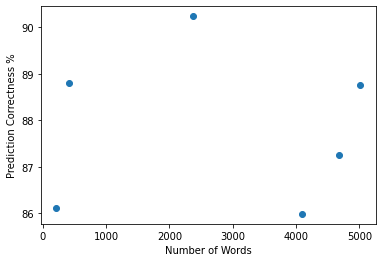

Frequency:[=1, <=10, <=20, Top5%, Top10%, Top20%]
X-axis:[2372, 417, 211, 5016, 4680, 4096]
Y-axis:[90.23485784919654, 88.8030888030888, 86.11825192802057, 88.75739644970415, 87.25961538461539, 85.99033816425121]
Task 2.1 done. Program terminated.


In [10]:
# Step 1: Run Driver for Part 1 once above if you have never yet
# Step 2: Run this cell
global vocabulary
orgVocabulary = vocabulary.copy()
wordsLeftInVocabFreqList = []
removedWords = {}

# to remove all the frequencies of 1 in the vocabulary
# Due to Smoothing: [1,1] means freq 0 which never happens, so at least we will have [2,1] so the sum is 3, so <=3 means 'freq of 1'
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] <= 3:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequency1-model.txt')
testingModel('frequency1-result.txt')

# to remove all the frequencies of <= 10 in the vocabulary
# Due to Smoothing: frequency of 10 means sum of 12
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] <= 12:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequency10-model.txt')
testingModel('frequency10-result.txt')

# to remove all the frequencies of <= 20 in the vocabulary
# Due to Smoothing: frequency of 20 means sum of 22
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] <= 22:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequency20-model.txt')
testingModel('frequency20-result.txt')

# Resetting modified vocabulary to original state
vocabulary = orgVocabulary.copy()

# remove the top 5% most frequent words
frequencySumList = [v[0]+v[1] for v in vocabulary.values()]
topFiveFreqValue = np.percentile(frequencySumList, 95)
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] >= topFiveFreqValue:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequencyTop5-model.txt')
testingModel('frequencyTop5-result.txt')
vocabulary = orgVocabulary.copy()

# remove the top 10% most frequent words
frequencySumList = [v[0]+v[1] for v in vocabulary.values()]
topTenFreqValue = np.percentile(frequencySumList, 90)
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] >= topTenFreqValue:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequencyTop10-model.txt')
testingModel('frequencyTop10-result.txt')
vocabulary = orgVocabulary.copy()

# remove the top 20% most frequent words
frequencySumList = [v[0]+v[1] for v in vocabulary.values()]
topTwentyFreqValue = np.percentile(frequencySumList, 80)
for word in list(vocabulary):  
    if vocabulary[word][0] + vocabulary[word][1] >= topTwentyFreqValue:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('frequencyTop20-model.txt')
testingModel('frequencyTop20-result.txt')
vocabulary = orgVocabulary.copy()

# Adding removedWords to remove.txt
with open('remove.txt', 'a') as f:
    for removedWord in removedWords.keys():
        f.write(removedWord + "\n")
    f.close()

# Plotting
fileNames = ['frequency1-result.txt', 'frequency10-result.txt', 'frequency20-result.txt', 'frequencyTop5-result.txt', 'frequencyTop10-result.txt', 'frequencyTop20-result.txt']
correctnessList = []
for fileName in fileNames:
    with open(fileName) as f:
        line = f.readline()
        while line:
            if 'The prediction correctness is' in line:
                correctnessList.append(float(re.findall(r'\b\d+.*\d+\b', line)[0]))
            line = f.readline()
        f.close()

plt.plot(wordsLeftInVocabFreqList, correctnessList, 'o')
plt.xlabel("Number of Words")
plt.ylabel("Prediction Correctness %")
plt.show()
print('Frequency:[=1, <=10, <=20, Top5%, Top10%, Top20%]')
print('X-axis:' + str(wordsLeftInVocabFreqList))
print('Y-axis:' + str(correctnessList))
print('Task 2.1 done. Program terminated.')

# Driver Task 2.3 Word Length Filtering

P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done
P(Positive) = 0.7519083969465649
P(Negative) = 0.2480916030534351
buildingModel Done
Testing Model with all 524 reviews in the testing data set...
testingModel Done


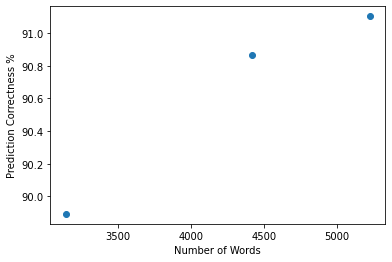

WordLength:[<=2, <=4, >=9]
X-axis:[5227, 4420, 3144]
Y-axis:[91.10320284697508, 90.86595492289442, 89.89298454221165]
Task 2.3 done. Program terminated.


In [11]:
# Step 1: Run Driver for Part 1 once above if you have never yet
# Step 2: Run this cell
global vocabulary
orgVocabulary = vocabulary.copy()
wordsLeftInVocabFreqList = []
removedWords = {}

# to remove all the words in vocabulary with length <= 2
for word in list(vocabulary):  
    if len(word) <= 2:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('length2-model.txt')
testingModel('length2-result.txt')

# to remove all the words in vocabulary with length <= 4
for word in list(vocabulary):  
    if len(word) <= 4:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('length4-model.txt')
testingModel('length4-result.txt')

# to remove all the words in vocabulary with length >= 9
for word in list(vocabulary):  
    if len(word) >= 9:
        vocabulary.pop(word)
        removedWords[word] = 0

wordsLeftInVocabFreqList.append(len(vocabulary))
buildingModel('length9-model.txt')
testingModel('length9-result.txt')


# Resetting modified vocabulary to original state
vocabulary = orgVocabulary.copy()

# Adding removedWords to remove.txt
with open('remove.txt', 'a') as f:
    for removedWord in removedWords.keys():
        f.write(removedWord + "\n")
    f.close()

# Plotting
fileNames = ['length2-result.txt', 'length4-result.txt', 'length9-result.txt']
correctnessList = []
for fileName in fileNames:
    with open(fileName) as f:
        line = f.readline()
        while line:
            if 'The prediction correctness is' in line:
                correctnessList.append(float(re.findall(r'\b\d+.*\d+\b', line)[0]))
            line = f.readline()
        f.close()

plt.plot(wordsLeftInVocabFreqList, correctnessList, 'o')
plt.xlabel("Number of Words")
plt.ylabel("Prediction Correctness %")
plt.show()
print('WordLength:[<=2, <=4, >=9]')
print('X-axis:' + str(wordsLeftInVocabFreqList))
print('Y-axis:' + str(correctnessList))
print('Task 2.3 done. Program terminated.')